In [92]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

from IPython.display import HTML

import sys
sys.path.append("../src")
import util

In [205]:
subject = "P01"
model = "SQuAD"
layers = [2, 5, 8, 11]

n_filter = 1000

In [145]:
brain_path = "../data/brains/%s/examples_384sentences.mat" % subject

In [146]:
subject_images, coords = util.load_brain_data(brain_path,
                                            downsample=3,
                                            ret_coords=True)

In [212]:
decoder_pred_path = "/om2/user/jgauthie/scratch/nn-decoding/models/encoders/encodings.finetune-250.uncased_L-12_H-768_A-12.%s-run1-250-layer%%i-%s.whole-brain-down3.pred.npy" % (model, subject)
predictions = [np.load(decoder_pred_path % layer) for layer in layers]
errors = np.array([mean_squared_error(subject_images, predictions_i, multioutput="raw_values")
                   for predictions_i in predictions])

In [213]:
# Threshold at highest performing super-voxels
best = errors.min(axis=0).argsort()[:n_filter]
errors_filtered, coords_filtered = errors[:, best], coords[best]

In [214]:
# Normalize errors within super-voxel
errors_filtered -= errors_filtered.min(axis=0)
errors_filtered /= errors_filtered.max(axis=0)

In [215]:
def render_errors(layer_idx):
    cmap = plt.get_cmap("hot")
    ax.clear()
    ax.scatter(coords_filtered[:, 0], coords_filtered[:, 1], coords_filtered[:, 2], c=errors_filtered[layer_idx], cmap=cmap)

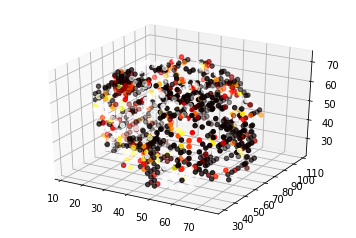

In [216]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_xlim((0, coords_filtered[:, 0].max()))
ax.set_ylim((0, coords_filtered[:, 1].max()))
ax.set_zlim((0, coords_filtered[:, 2].max()))
graph = ax.scatter(*np.tile(0, (3, n_filter)))
ani = FuncAnimation(fig, render_errors, 4, interval=200, blit=False, repeat=False)
# import matplotlib.colorbar
# ax2 = fig.add_subplot(121)
# cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap)

In [217]:
HTML(ani.to_html5_video())

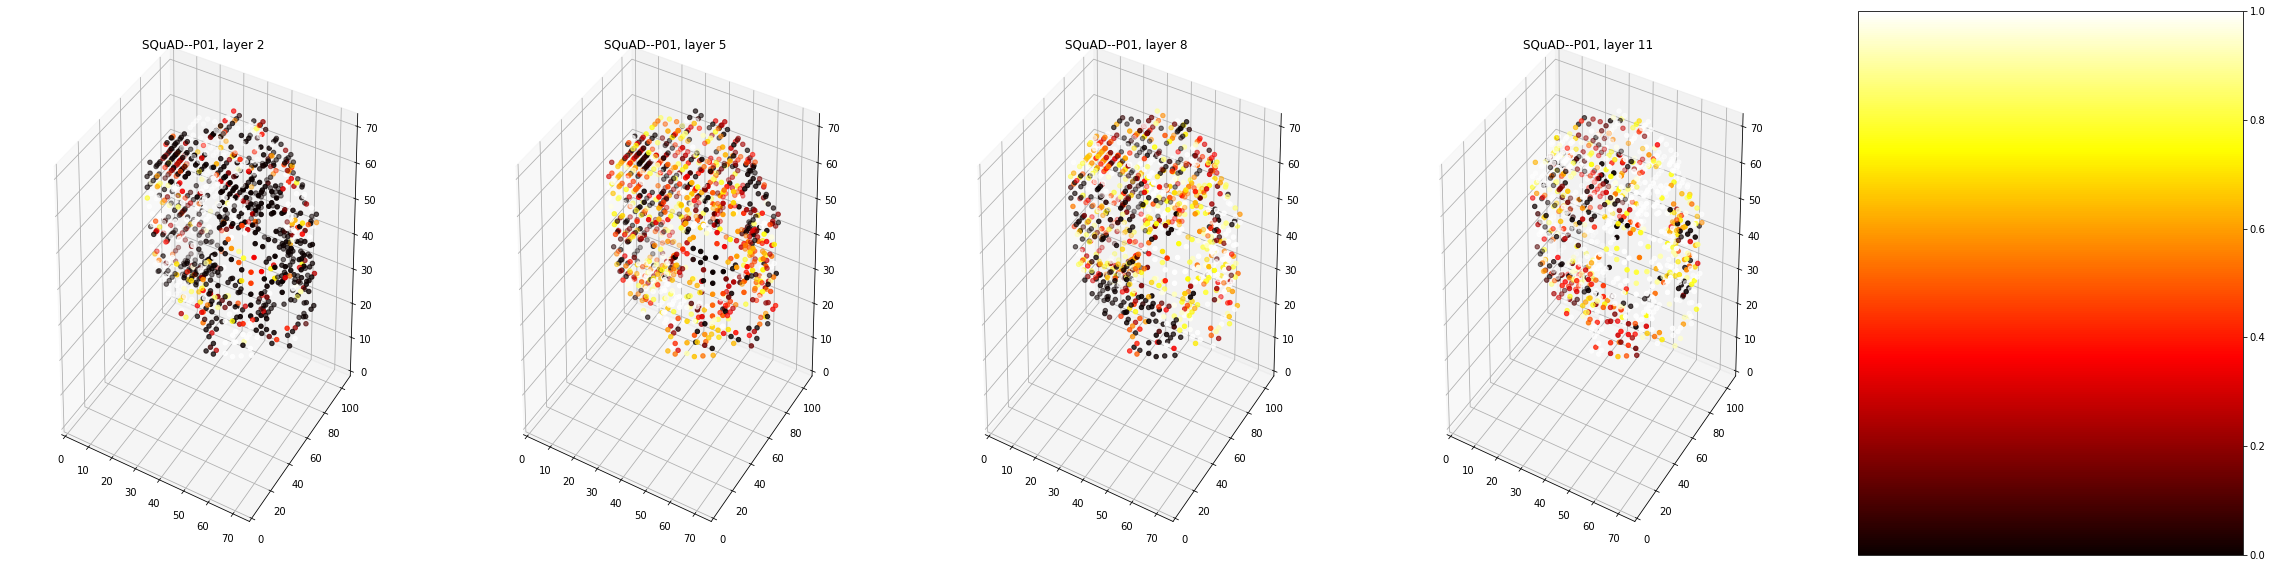

In [229]:
fig = plt.figure(figsize=(40, 10))# , axs = plt.subplots(1, len(layers), projection="3d")
cmap = plt.get_cmap("hot")
for (layer_idx, layer), ax in zip(enumerate(layers), axs):
    ax = fig.add_subplot(1, len(layers) + 1, 1 + layer_idx, projection="3d")
    ax.set_xlim((0, coords_filtered[:, 0].max()))
    ax.set_ylim((0, coords_filtered[:, 1].max()))
    ax.set_zlim((0, coords_filtered[:, 2].max()))
    
    ax.scatter(coords_filtered[:, 0], coords_filtered[:, 1], coords_filtered[:, 2], c=errors_filtered[layer_idx], cmap=cmap)
    ax.set_title("%s--%s, layer %d" % (model, subject, layer))
    
ax = fig.add_subplot(1, len(layers) + 1, len(layers) + 1)
from matplotlib.colorbar import ColorbarBase
ColorbarBase(ax, cmap=cmap)